# Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math
import os

In [3]:
plt.style.use('seaborn-whitegrid')

In [4]:
from fastai.imports import *
from fastai.structured import *

In [5]:
TRAIN_CSV = 'data/nyc-taxi/train.csv'
TEST_CSV = 'data/nyc-taxi/test.csv'

# Load training and test data

The entire dataset has about 55,423,857 rows

In [6]:
types = {'fare_amount': 'float32',
         'pickup_longitude': 'float32',
         'pickup_latitude': 'float32',
         'dropoff_longitude': 'float32',
         'dropoff_latitude': 'float32',
         'passenger_count': 'uint8'}

# Columns to keep (basically discarding the 'key' column)
cols_train = ['fare_amount', 'pickup_datetime', 'pickup_longitude', 
        'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'pickup_datetime']

# No 'fare_amount'
cols_test = ['pickup_datetime', 'pickup_longitude', 
        'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'pickup_datetime']

In [7]:
df_list = [] # list to hold the batch dataframe
chunksize = 10_000_000 # 10 million rows at one go. Or try 10 million
total_chunk = 55423857 // chunksize + 1

print(f'Chunk size: {chunksize:,}\nTotal chunks required: {total_chunk}')

Chunk size: 10,000,000
Total chunks required: 6


In [7]:
%%time
i=0
for df_chunk in pd.read_csv(TRAIN_CSV, usecols=cols_train, dtype=types, chunksize=chunksize):
    
    i = i+1
    print(f'DataFrame Chunk {i}/{total_chunk}')
    
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], format='%Y-%m-%d %H') 
    
    df_list.append(df_chunk) 

DataFrame Chunk 1/6
DataFrame Chunk 2/6
DataFrame Chunk 3/6
DataFrame Chunk 4/6
DataFrame Chunk 5/6
DataFrame Chunk 6/6
Wall time: 1min 36s


In [8]:
train_df = pd.concat(df_list)

del df_list

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns](1), float32(5), uint8(1)
memory usage: 1.5 GB


In [10]:
display(train_df.head())
display(train_df.tail())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00,-73.968094,40.768009,-73.956657,40.783764,1


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
55423851,14.0,2014-03-15 03:28:00,-74.005272,40.740028,-73.963280,40.762554,1
55423852,4.2,2009-03-24 20:46:00,-73.957787,40.765530,-73.951637,40.773960,1
55423853,14.1,2011-04-02 22:04:00,-73.970505,40.752323,-73.960541,40.797340,1
55423854,28.9,2011-10-26 05:57:00,-73.980904,40.764629,-73.870605,40.773964,1
55423855,7.5,2014-12-12 11:33:00,-73.969719,40.797668,-73.970886,40.783314,1


In [11]:
%%time
os.makedirs('tmp', exist_ok=True)
train_df.to_feather('tmp/taxi-train-raw')

Wall time: 5.79 s


In [8]:
%%time
train_df = pd.read_feather('tmp/taxi-train-raw')

CPU times: user 571 ms, sys: 1.18 s, total: 1.75 s
Wall time: 9.14 s


In [9]:
test_df = pd.read_csv(TEST_CSV, usecols=cols_test, dtype=types)
test_df['pickup_datetime'] = test_df['pickup_datetime'].str.slice(0, 16)
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'], format='%Y-%m-%d %H') 

In [10]:
test_df.to_feather('tmp/taxi-test-raw')

# Remove missing values

In [11]:
train_df.isnull().sum() 

fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64

In [12]:
test_df.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [13]:
old_len = len(train_df)
print(f'Old size: {old_len}')

train_df.dropna(how='any', axis='rows', inplace=True)

new_len = len(train_df)
print(f'New size: {old_len}')
print(f'{(old_len-new_len):,} rows removed')

Old size: 55423856
New size: 55423856
376 rows removed


# Longitude and latitude

In [14]:
# Set limits manually
longmin_limit = -80
longmax_limit = -70
latmin_limit = 35
latmax_limit = 45

In [15]:
is_outside_plong = ~train_df.pickup_longitude.between(longmin_limit,longmax_limit)
is_outside_plat = ~train_df.pickup_latitude.between(latmin_limit,latmax_limit)

is_outside_dlong = ~train_df.dropoff_longitude.between(longmin_limit,longmax_limit)
is_outside_dlat = ~train_df.dropoff_latitude.between(latmin_limit,latmax_limit)

is_outside_plong.sum(), is_outside_plat.sum(), is_outside_dlong.sum(), is_outside_dlat.sum()

(1094190, 1087077, 1090142, 1084481)

In [16]:
is_outside_range = is_outside_plong | is_outside_plat | is_outside_dlong | is_outside_dlat
is_outside_range.sum()

1150750

In [17]:
old_len = len(train_df)
print(f'Old size: {old_len}')

train_df = train_df[~is_outside_range] # keep those NOT outside range

new_len = len(train_df)
print(f'New size: {new_len}')
print(f'{(old_len-new_len):,} rows removed')

Old size: 55423480
New size: 54272730
1,150,750 rows removed


# Passenger Count

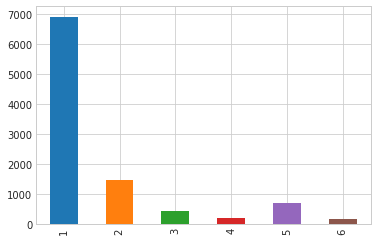

In [19]:
test_df.passenger_count.value_counts(sort=False).plot(kind='bar')

In [20]:
test_df.passenger_count.value_counts()

1    6914
2    1474
5     696
3     447
4     206
6     177
Name: passenger_count, dtype: int64

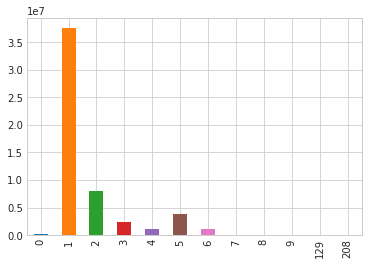

In [21]:
train_df.passenger_count.value_counts(sort=False).plot(kind='bar')

In [22]:
train_df.passenger_count.value_counts().sort_index()

0        190847
1      37532471
2       8016490
3       2384102
4       1155925
5       3842499
6       1150331
7            13
8             7
9            21
129           2
208          22
Name: passenger_count, dtype: int64

In [23]:
# number rows with passenger = 0 or more than 6
len(train_df[~(train_df.passenger_count.between(1,6))])

190912

In [24]:
old_len = len(train_df)
print(f'Old size: {old_len}')

train_df = train_df[(train_df.passenger_count.between(1,6))]

new_len = len(train_df)
print(f'New size: {new_len}')
print(f'{(old_len-new_len):,} rows removed')

Old size: 54272730
New size: 54081818
190,912 rows removed


# Fare Amount

In [25]:
train_df.fare_amount.median(), train_df.fare_amount.mean()

(8.5, 11.3355255)

In [26]:
fare_max = 150
fare_min = 0

len(train_df[~(train_df.fare_amount.between(fare_min,fare_max))])

6507

In [27]:
old_len = len(train_df)
print(f'Old size: {old_len}')

train_df = train_df[(train_df.fare_amount.between(fare_min,fare_max))]

new_len = len(train_df)
print(f'New size: {new_len}')
print(f'{(old_len-new_len):,} rows removed')

Old size: 54081818
New size: 54075311
6,507 rows removed


# Checkpoint 1

In [28]:
# reset_index after removing rows, in order to be able to save to feather
train_df.reset_index(drop=True, inplace=True)

In [29]:
%%time
train_df.to_feather('tmp/taxi-train-v10-chkpt1')

CPU times: user 2.27 s, sys: 1.17 s, total: 3.45 s
Wall time: 2.34 s


In [30]:
%%time
test_df.to_feather('tmp/taxi-test-v10-chkpt1')

CPU times: user 5.79 ms, sys: 187 µs, total: 5.98 ms
Wall time: 4.14 ms


In [31]:
%%time
train_df = pd.read_feather('tmp/taxi-train-v10-chkpt1')

CPU times: user 344 ms, sys: 887 ms, total: 1.23 s
Wall time: 1.23 s


In [32]:
%%time
test_df = pd.read_feather('tmp/taxi-test-v10-chkpt1')

CPU times: user 2.24 ms, sys: 1.06 ms, total: 3.3 ms
Wall time: 2.88 ms


# Date Time

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54075311 entries, 0 to 54075310
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns](1), float32(5), uint8(1)
memory usage: 1.5 GB


In [34]:
def split_datetime(df):
    # Extract date attributes and then drop the pickup_datetime column
    df['year'] = (df['pickup_datetime'].dt.year-2000).astype('uint8')  
    df['month'] = df['pickup_datetime'].dt.month.astype('uint8')  
    df['week'] = df['pickup_datetime'].dt.week.astype('uint8')  
    df['dayofweek'] = df['pickup_datetime'].dt.dayofweek.astype('uint8')  
    df['day'] = df['pickup_datetime'].dt.day.astype('uint8')  
    df['hour'] = df['pickup_datetime'].dt.hour.astype('uint8')  
    
    df.drop('pickup_datetime', axis=1, inplace=True)

In [35]:
%%time
split_datetime(train_df)

CPU times: user 20.4 s, sys: 3.82 s, total: 24.2 s
Wall time: 24 s


In [36]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54075311 entries, 0 to 54075310
Data columns (total 12 columns):
fare_amount          float32
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
year                 uint8
month                uint8
week                 uint8
dayofweek            uint8
day                  uint8
hour                 uint8
dtypes: float32(5), uint8(7)
memory usage: 1.4 GB


In [37]:
split_datetime(test_df)

# Checkpoint 2

In [38]:
%%time
train_df.to_feather('tmp/taxi-train-v10-chkpt2')

CPU times: user 2.58 s, sys: 1.04 s, total: 3.63 s
Wall time: 2.49 s


In [39]:
%%time
test_df.to_feather('tmp/taxi-test-v10-chkpt2')

CPU times: user 7.83 ms, sys: 1.4 ms, total: 9.23 ms
Wall time: 6.99 ms


In [62]:
%%time
train_df = pd.read_feather('tmp/taxi-train-v10-chkpt2')

CPU times: user 425 ms, sys: 1.27 s, total: 1.7 s
Wall time: 6.57 s


In [63]:
%%time
test_df = pd.read_feather('tmp/taxi-test-v10-chkpt2')

CPU times: user 2.24 ms, sys: 1.26 ms, total: 3.49 ms
Wall time: 5.72 ms


# Add travel vector and distance

In [64]:
def add_travel_vector_features(df):
    df['longitude_distance'] = df.dropoff_longitude - df.pickup_longitude
    df['latitude_distance'] = df.dropoff_latitude - df.pickup_latitude
    
    df['manhattan_distance'] = (df['longitude_distance']).abs() + (df['latitude_distance']).abs()
    df['distance_travelled'] = (df['longitude_distance'] ** 2 + df['latitude_distance'] ** 2) ** .5

In [65]:
add_travel_vector_features(train_df)
add_travel_vector_features(test_df)

# Checkpoint 3

In [66]:
%%time
train_df.to_feather('tmp/taxi-train-v10-Baseline')

CPU times: user 5.05 s, sys: 2.14 s, total: 7.18 s
Wall time: 27.6 s


In [67]:
%%time
test_df.to_feather('tmp/taxi-test-v10-Baseline')

CPU times: user 6.35 ms, sys: 5.27 ms, total: 11.6 ms
Wall time: 8.06 ms


In [68]:
train_df = pd.read_feather('tmp/taxi-train-v10-Baseline')

In [69]:
test_df = pd.read_feather('tmp/taxi-test-v10-Baseline')

In [70]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54075311 entries, 0 to 54075310
Data columns (total 16 columns):
fare_amount           float32
pickup_longitude      float32
pickup_latitude       float32
dropoff_longitude     float32
dropoff_latitude      float32
passenger_count       uint8
year                  uint8
month                 uint8
week                  uint8
dayofweek             uint8
day                   uint8
hour                  uint8
longitude_distance    float32
latitude_distance     float32
manhattan_distance    float32
distance_travelled    float64
dtypes: float32(8), float64(1), uint8(7)
memory usage: 2.4 GB


In [71]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 15 columns):
pickup_longitude      9914 non-null float32
pickup_latitude       9914 non-null float32
dropoff_longitude     9914 non-null float32
dropoff_latitude      9914 non-null float32
passenger_count       9914 non-null uint8
year                  9914 non-null uint8
month                 9914 non-null uint8
week                  9914 non-null uint8
dayofweek             9914 non-null uint8
day                   9914 non-null uint8
hour                  9914 non-null uint8
longitude_distance    9914 non-null float32
latitude_distance     9914 non-null float32
manhattan_distance    9914 non-null float32
distance_travelled    9914 non-null float32
dtypes: float32(8), uint8(7)
memory usage: 377.7 KB


# Add distance to city and airports

In [72]:
def dist(pickup_lat, pickup_long, dropoff_lat, dropoff_long):  
    return (np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)).astype('float32')  

In [73]:
def add_distance_to_city_airports(df):
    # Distances to nearby airports, and city center
    # By reporting distances to these points, the model can somewhat triangulate other locations of interest
    nyc = (40.712775,-74.005973) # New York City
    jfk = (40.641311,-73.778139) # John F. Kennedy International Airport
    ewr = (40.689531,-74.174462) # Newark Liberty International Airport
    lgr = (40.776927,-73.873966) # LaGuardia Airport
    
    df['pickup_distance_to_nyc'] = dist(nyc[0], nyc[1], df['pickup_latitude'], df['pickup_longitude'])
    df['dropoff_distance_to_nyc'] = dist(nyc[0], nyc[1], df['dropoff_latitude'], df['dropoff_longitude'])
    df['pickup_distance_to_jfk'] = dist(jfk[0], jfk[1], df['pickup_latitude'], df['pickup_longitude'])
    df['dropoff_distance_to_jfk'] = dist(jfk[0], jfk[1], df['dropoff_latitude'], df['dropoff_longitude'])
    df['pickup_distance_to_ewr'] = dist(ewr[0], ewr[1], df['pickup_latitude'], df['pickup_longitude'])
    df['dropoff_distance_to_ewr'] = dist(ewr[0], ewr[1], df['dropoff_latitude'], df['dropoff_longitude'])
    df['pickup_distance_to_lgr'] = dist(lgr[0], lgr[1], df['pickup_latitude'], df['pickup_longitude'])
    df['dropoff_distance_to_lgr'] = dist(lgr[0], lgr[1], df['dropoff_latitude'], df['dropoff_longitude'])

In [74]:
add_distance_to_city_airports(train_df)

In [75]:
add_distance_to_city_airports(test_df)

In [76]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54075311 entries, 0 to 54075310
Data columns (total 24 columns):
fare_amount                float32
pickup_longitude           float32
pickup_latitude            float32
dropoff_longitude          float32
dropoff_latitude           float32
passenger_count            uint8
year                       uint8
month                      uint8
week                       uint8
dayofweek                  uint8
day                        uint8
hour                       uint8
longitude_distance         float32
latitude_distance          float32
manhattan_distance         float32
distance_travelled         float64
pickup_distance_to_nyc     float32
dropoff_distance_to_nyc    float32
pickup_distance_to_jfk     float32
dropoff_distance_to_jfk    float32
pickup_distance_to_ewr     float32
dropoff_distance_to_ewr    float32
pickup_distance_to_lgr     float32
dropoff_distance_to_lgr    float32
dtypes: float32(16), float64(1), uint8(7)
memory usage: 4.0

# Add boolean flag to show fare increased from September 2012

In [77]:
def add_fare_increased_flag(df):
    flag = (((df.year==(2012-2000)) & (df.month>=9)) | (df.year>(2012-2000)))
    df['fare_increased'] = flag

In [78]:
add_fare_increased_flag(train_df)

In [79]:
add_fare_increased_flag(test_df)

# Checkpoint 4

In [80]:
%%time
train_df.to_feather('tmp/taxi-train-v10-Airport-Flag')

CPU times: user 7.78 s, sys: 2.9 s, total: 10.7 s
Wall time: 57.5 s


In [81]:
%%time
test_df.to_feather('tmp/taxi-test-v10-Airport-Flag')

CPU times: user 12.2 ms, sys: 2.53 ms, total: 14.8 ms
Wall time: 13.7 ms


In [82]:
train_df = pd.read_feather('tmp/taxi-train-v10-Airport-Flag')

In [83]:
test_df = pd.read_feather('tmp/taxi-test-v10-Airport-Flag')

In [84]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54075311 entries, 0 to 54075310
Data columns (total 25 columns):
fare_amount                float32
pickup_longitude           float32
pickup_latitude            float32
dropoff_longitude          float32
dropoff_latitude           float32
passenger_count            uint8
year                       uint8
month                      uint8
week                       uint8
dayofweek                  uint8
day                        uint8
hour                       uint8
longitude_distance         float32
latitude_distance          float32
manhattan_distance         float32
distance_travelled         float64
pickup_distance_to_nyc     float32
dropoff_distance_to_nyc    float32
pickup_distance_to_jfk     float32
dropoff_distance_to_jfk    float32
pickup_distance_to_ewr     float32
dropoff_distance_to_ewr    float32
pickup_distance_to_lgr     float32
dropoff_distance_to_lgr    float32
fare_increased             bool
dtypes: bool(1), float32(16